In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression


In [2]:
#combine all CSV files into a data frame

all_dfs = []

for i in range(17, 25):
    file_path = f'/content/drive/My Drive/Mdot_RoadProject/20{i}output.csv'
    df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='error')
    all_dfs.append(df)

df_paser = pd.concat(all_dfs, ignore_index=True)


# Road name CSV to data frame
df_RH = pd.read_csv('/content/drive/My Drive/Mdot_RoadProject/2025RHoutput.csv')



/tmp/ipython-input-362225767.py:14: DtypeWarning: Columns (9,13,14,15,16,17,32,41,42,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_RH = pd.read_csv('/content/drive/My Drive/Mdot_RoadProject/2025RHoutput.csv')


In [3]:
#MERGING DF_paser and DF_RH

df_paser['PRNo'] = df_paser['PRNo'].astype(str).str.strip()
df_RH['PR'] = df_RH['PR'].astype(str).str.strip()

mi_df = pd.merge(df_paser, df_RH[['PR', 'FENAME', 'AADT', 'COUNTYL']], left_on='PRNo', right_on='PR', how='inner')
mi_df.drop(['FwkVersion', 'NumLanes', 'RoadOwner','SourceID','IsOfficial','geometry', 'PRNo'], axis=1, inplace=True)


In [4]:
#Data Cleaning for DF
mi_df.drop(mi_df[mi_df['AADT'] < 0].index, inplace=True)
mi_df.drop_duplicates(inplace=True)

#Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)



Index(['AADT', 'PASERRating'], dtype='object')


/tmp/ipython-input-247764031.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


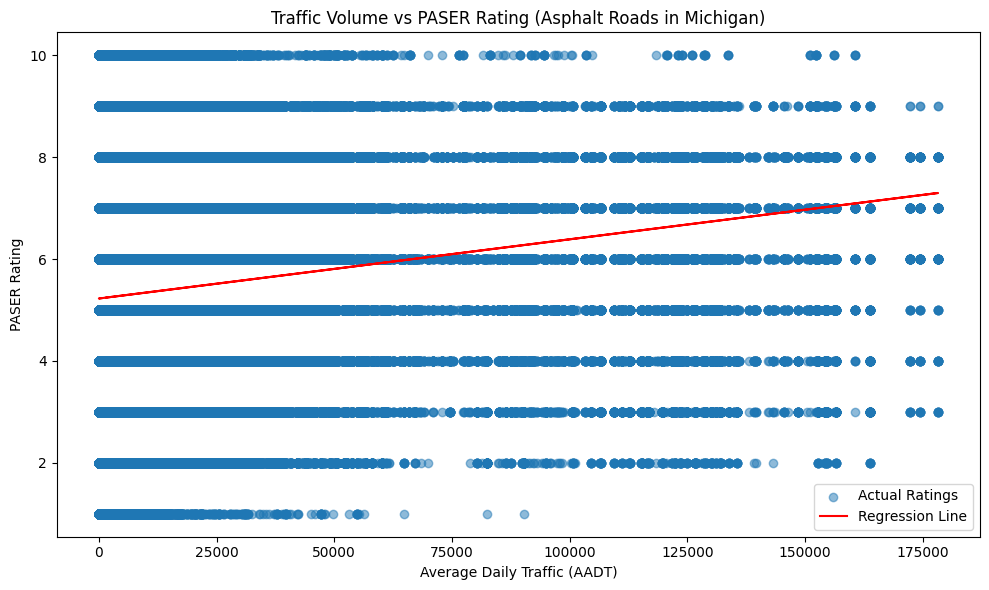

Slope: 0.0000
Intercept: 5.2255
R^2 score: 0.0067


In [5]:

# Linear regression for average daily traffic to predict PASER Rating for asphalt (ALL of Michigan):
# Data exploration, linear regression shows no useful information

asphalt_df = mi_df[mi_df['SurfType'] == 'Asphalt']
asphalt_df = asphalt_df[['AADT', 'PASERRating']].dropna()

X = asphalt_df['AADT'].values.reshape(-1, 1)
y = asphalt_df['PASERRating'].values


print(asphalt_df.columns)


model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Actual Ratings')
plt.plot(X, y_pred, color='red', label='Regression Line')

plt.title('Traffic Volume vs PASER Rating (Asphalt Roads in Michigan)')
plt.xlabel('Average Daily Traffic (AADT)')
plt.ylabel('PASER Rating')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Slope: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R^2 score: {model.score(X, y):.4f}")

In [6]:
#Filtering Data set for road segments that appear every single year,
#this is to see what potential statistical models would fit best

years_present = mi_df['RatingYear'].nunique()

#for every year, grouping which ones have the same PR
pr_year_counts = mi_df.groupby('PR')['RatingYear'].nunique()
valid_prs = pr_year_counts[pr_year_counts == years_present].index



everyYear_df = mi_df[mi_df['PR'].isin(valid_prs)].copy()
everyYear_df.drop_duplicates(inplace = True)
everyYear_df.drop(['CollectDate', 'Shape_Length', 'COUNTYL'], axis = 1, inplace= True)


In [7]:
#Grouping road segments which appeared each year

group_counts = everyYear_df.groupby(['PR', 'BMP', 'EMP'])['RatingYear'].nunique()
valid_combos = group_counts[group_counts == years_present].index
matching_df = everyYear_df.set_index(['PR', 'BMP', 'EMP']).loc[valid_combos].reset_index()
matching_df.to_csv('matching_segments.csv', index=False)



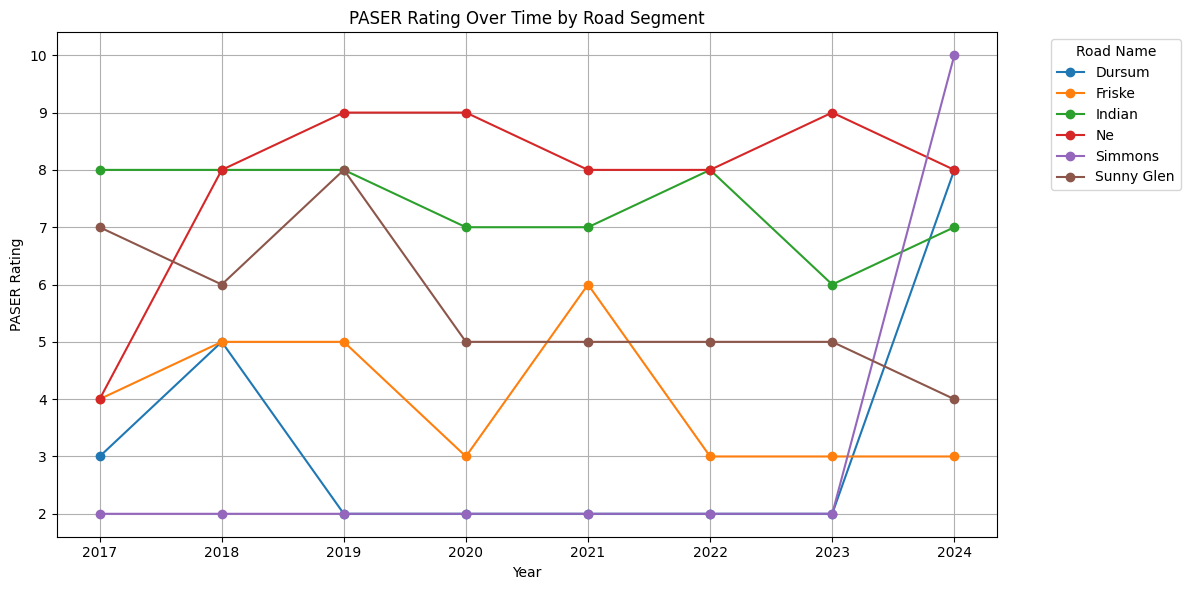

In [8]:
# Plotting each road segment

plt.figure(figsize=(12, 6))

for name, group in matching_df.groupby('FENAME'):
    plt.plot(group['RatingYear'], group['PASERRating'], marker='o', label=name)

plt.xlabel('Year')
plt.ylabel('PASER Rating')
plt.title('PASER Rating Over Time by Road Segment')
plt.legend(title='Road Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

In [9]:
# Averaging Asphalts, concrete, gravel in Michigan


mi_df.dropna(subset=['AADT'], inplace=True)
mi_df.drop(mi_df[mi_df['AADT'] < 0].index, inplace=True)
mi_df.dropna(subset=['PASERRating'], inplace=True)

for surf in mi_df['SurfType'].unique():
  average = mi_df.loc[ mi_df['SurfType'] == surf, 'PASERRating'].mean()
  print(f"average {surf} rating:" , f"{average:.2f}")


average Asphalt rating: 5.32
average Concrete rating: 5.92
average Composite rating: 5.67
average Seal Coat rating: 4.92
average Gravel rating: 5.80
average Earth rating: 2.54
average Brick rating: 5.76
average Composite 27 rating: 8.38


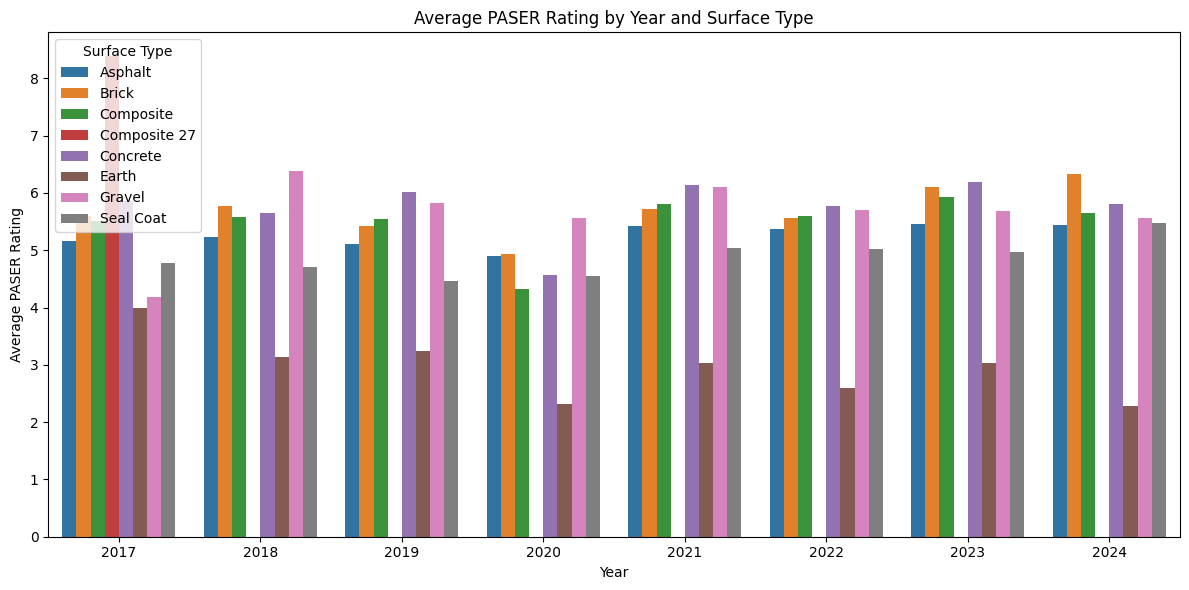

In [10]:
# Bar chart
# average rating of each surface type, grouped by year
averages_by_year =  mi_df.groupby(['RatingYear', 'SurfType'])['PASERRating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=averages_by_year, x='RatingYear', y='PASERRating', hue='SurfType')

plt.title('Average PASER Rating by Year and Surface Type')
plt.xlabel('Year')
plt.ylabel('Average PASER Rating')
plt.legend(title='Surface Type')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1506309743.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = mi_df.groupby('AADT_bin')['PASERRating'].mean().reset_index()


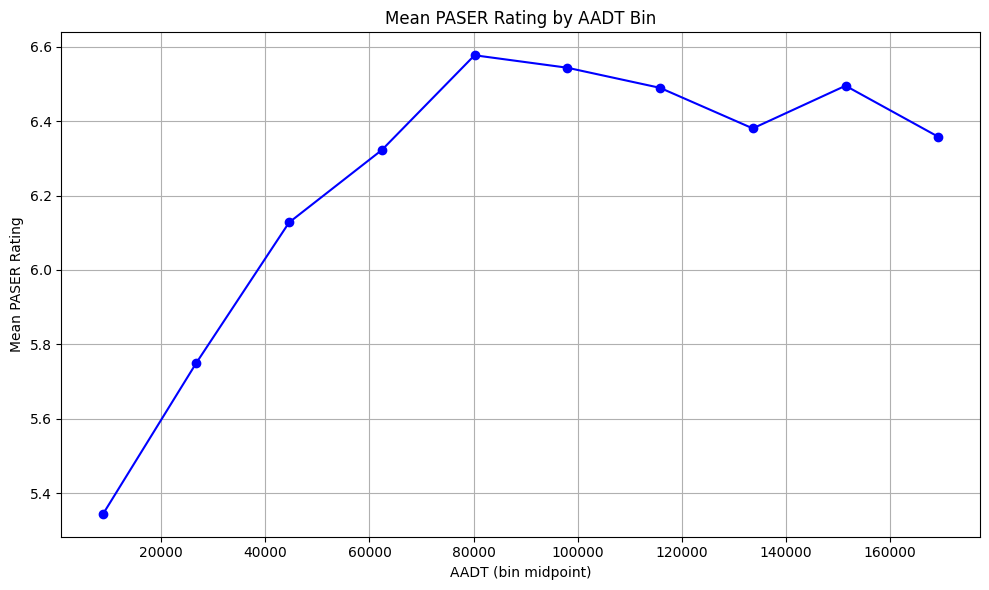

In [11]:
# Averaging daily traffic by bins and getting paser rating line for each surface type
plt.figure(figsize=(10, 6))

mi_df['AADT_bin'] = pd.cut(mi_df['AADT'], bins=10)
bin_means = mi_df.groupby('AADT_bin')['PASERRating'].mean().reset_index()

bin_means['bin_midpoint'] = bin_means['AADT_bin'].apply(lambda x: x.mid)

#plotting

plt.plot(bin_means['bin_midpoint'], bin_means['PASERRating'], marker='o', linestyle='-', color='blue')
plt.xlabel('AADT (bin midpoint)')
plt.ylabel('Mean PASER Rating')
plt.title('Mean PASER Rating by AADT Bin')
plt.grid(True)
plt.tight_layout()
plt.show()






In [ ]:
#Modeling PHcox model for asphalt roads in MI

mi_df.sort_values(by=['PR', 'BMP', 'EMP', 'RatingYear'], inplace=True)
mi_df['paser_diff'] = mi_df.groupby(['PR', 'BMP', 'EMP'])['PASERRating'].diff()
mi_df['event'] = ((mi_df['PASERRating'] <= 3) | (mi_df['paser_diff'] > 3)).astype(int)
mi_df['duration'] = mi_df.groupby(['PR', 'BMP', 'EMP'])['RatingYear'].transform(lambda x: x - x.min())


In [ ]:
from lifelines import CoxPHFitter

mi_df = mi_df[mi_df['SurfType'] == 'Asphalt']

cox_input = mi_df.groupby(['PR', 'BMP', 'EMP'], as_index=False).last()

# cleaning data
cox_input = cox_input[cox_input['AADT'] >= 0]
cox_input.dropna(subset=['duration', 'event', 'AADT'], inplace=True)

# Fitting model
cox_input['duration_bin'] = pd.cut(cox_input['duration'], bins=[0, 3, 6, 10], labels=['0–3', '4–6', '7+'])
cox_input = pd.get_dummies(cox_input, columns=['duration_bin'], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_input[['duration', 'event', 'AADT', 'duration_bin_4–6', 'duration_bin_7+']],
        duration_col='duration', event_col='event')
cph.print_summary()
